In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
import myfunc as mf


In [6]:
import pandas as pd

# Data for the DataFrame
data = {
    "Sample": np.arange(1,51,1),
    "Concentration": [8.36, 12.72, 8.60, 7.72, 5.97, 5.43, 4.32, 5.58, 4.59, 6.94, 
                      3.56, 7.71, 1.57, 7.32, 3.95, 6.31, -0.23, -0.35, 3.23, 7.38, 
                      4.73, 7.96, 11.58, 14.99, 8.21, 8.83, 7.54, 12.35, 6.27, 8.68, 
                      11.27, 10.37, 12.30, 10.62, 13.89, 15.08, 13.30, 19.47, 18.25, 
                      17.26, 19.67, 17.15, 18.17, 19.59, 16.13, 17.08, 13.49, 13.55, 
                      16.34, 10.95]
}

# Creating the DataFrame
data= pd.DataFrame(data)

# Displaying the DataFrame
data.head()


,Sample,Concentration
0,1,8.36
1,2,12.72
2,3,8.60
3,4,7.72
4,5,5.97


In [7]:
data['dummy_neg']=np.where(data['Concentration']<0, 1, 0)


In [8]:
c=data['Concentration']

Number of points n = 50
Mean = 10.11


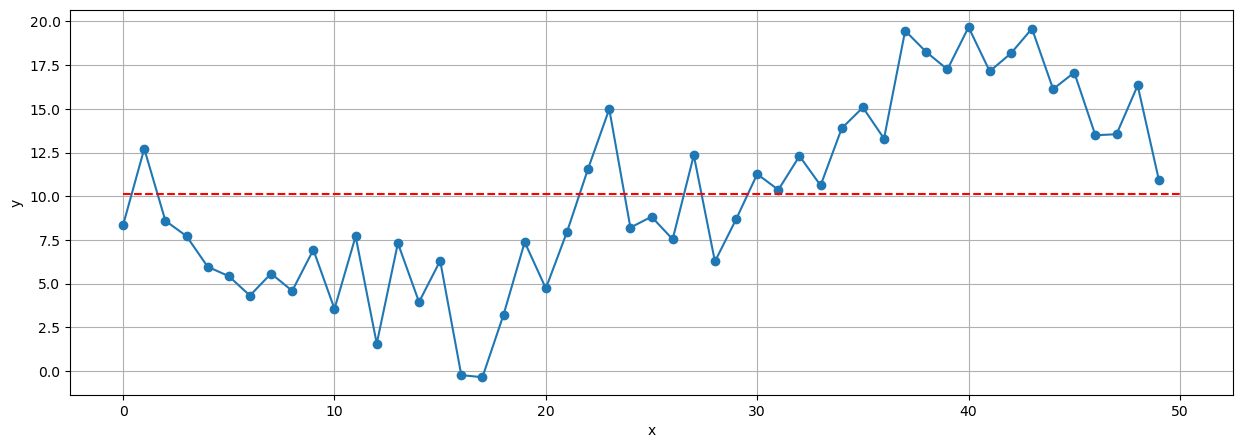

In [9]:
mf.single_ts_plot(c)

p-value of the Shapiro-Wilk test: 0.22280
Accept H0: the data are normal


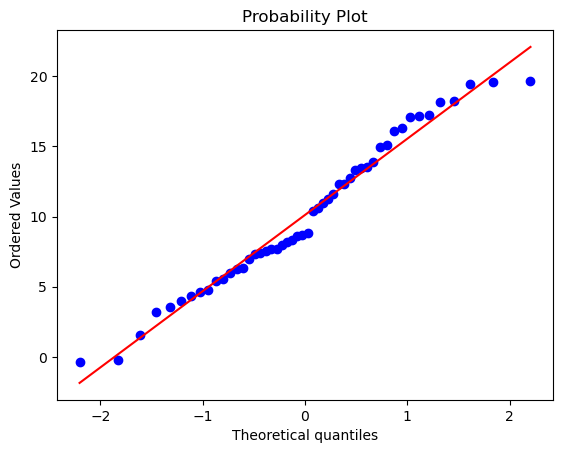

In [10]:
mf.shapiroqq(c)

Runs test statistic = -5.141
Runs test p-value = 0.00000
Reject H0: the data are not random


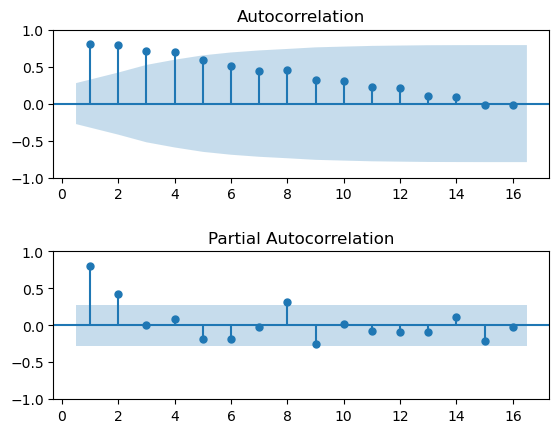

In [11]:
mf.runs(c)
mf.acfpacf(c)

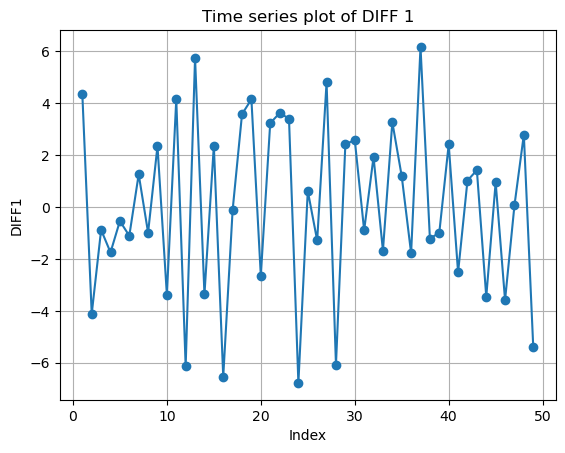

Runs test statistic = 3.03598
Runs test p-value = 0.00240
Reject H0: the data are not random


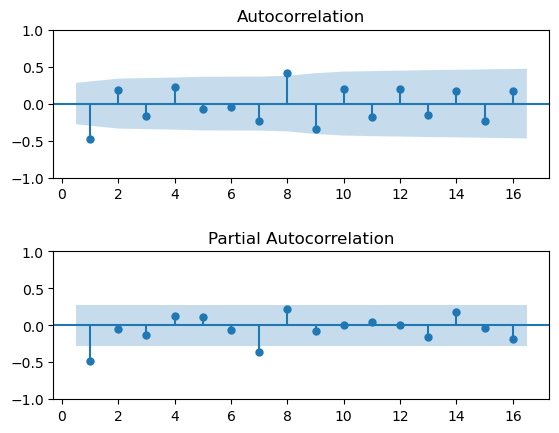

In [12]:
data['lag1']=c.shift(1)
c_diff=mf.diffprocess(data,'Concentration','lag1',1)

a questo punto per me il top sarebbe una ARIMA(0,1,1), ma è sbatti, meglio provare ARIMA(1,1,0)
e mettere la dummy!

In [19]:
import statsmodels.api as sm
import qda
data['lag1_diff']=c_diff.shift(1) #il lga1 lo devo creare per la time series differenziata
x = data[['lag1_diff', 'dummy_neg']].iloc[2:,:]
diff = c_diff.iloc[2:]



In [20]:
model = sm.OLS(diff, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
y =  -0.540 lag1_diff -4.459 dummy_neg

COEFFICIENTS
------------
     Term    Coef  SE Coef  T-Value    P-Value
lag1_diff -0.5401   0.1235  -4.3740 6.9315e-05
dummy_neg -4.4589   1.9785  -2.2537 2.9023e-02

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
2.7633 0.3237     0.2943

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS  F-Value    P-Value
Regression  2.0 169.4052  84.7026  11.0068 1.2409e-04
 lag1_diff  1.0 147.2274 147.2274  19.1316 6.9315e-05
 dummy_neg  1.0  39.0870  39.0870   5.0792 2.9023e-02
     Error 46.0 353.9933   7.6955      NaN        NaN
     Total 48.0 523.3985      NaN      NaN        NaN


Shapiro-Wilk test p-value on the residuals = 0.34606


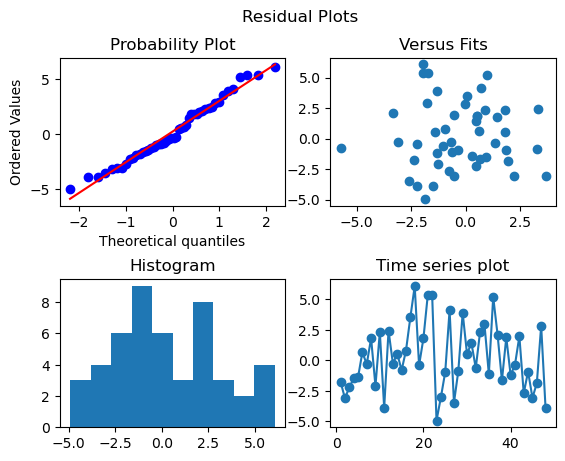

In [21]:
mf.shapirplusresplots(model)

Runs test statistic = 1.225
Runs test p-value = 0.22076
Accept H0: the data are random


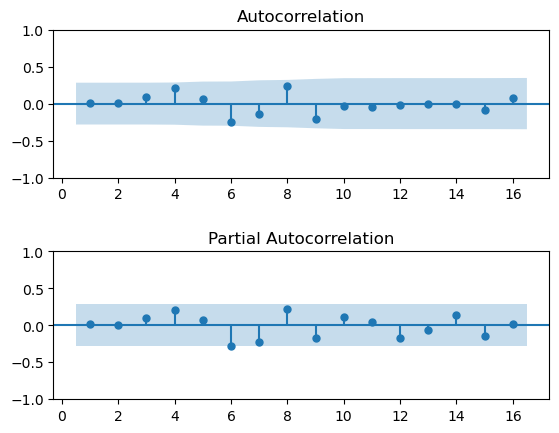

In [22]:
mf.runs(model.resid)
mf.acfpacf(model.resid)

Based on the result of point a), estimate the 95% prediction interval for the contaminant concentration in 
the next sample.

In [28]:
#ARIMA(1,1,0) fatto a mano (toccava per via della dummy)
#attenzione qui che devo prendere l'ultimo di c_diff, non l'ultimo lag!!!
last_lag = c_diff.iloc[-1] #in questo caso -1 perché regressore era lag1 e cosi prendo effettivamente l’ultimo campione presente, se no altri due modi per prelevarlo:
last_dummy=0
prediction_df = model.get_prediction([last_lag,last_dummy]).summary_frame(alpha=0.05)
print(prediction_df)
#da sommare però visto che calcolo la diff c'è l'ultimo....?
#visto che delta_Xt=Xt-Xt-1 avrei detto che avrei dovuto sommare l'ultimo lag1
#ma sono interessato a t=51
#delta_X51=X51-X50 quindi X51=delta_X51+X50
#e quello che ho stimato con le istruzioni sopra è delta_X51, ora devo sommare X50
tosum=c.iloc[-1]
print(tosum)
pred_low=-2.831+10.95
pred_up=8.65+10.95
print(pred_low)
print(pred_up)

     mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  2.9114   0.6656         1.5716         4.2512        -2.831        8.6538
10.95
8.119
19.6


Based on the result of point a), design an appropriate control chart for these data with ARL0 = 250.  

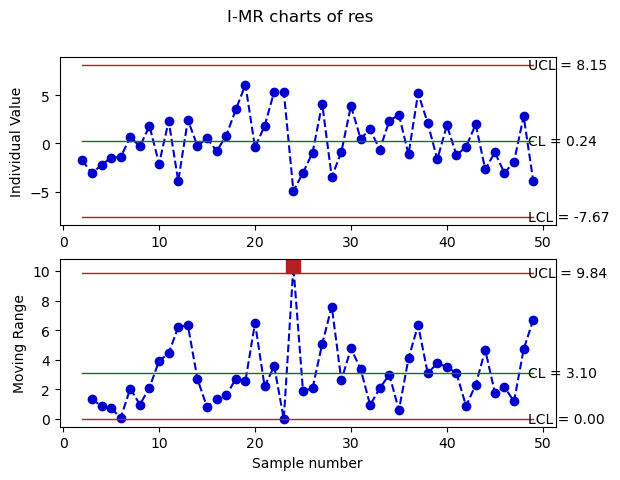

In [30]:
alpha=1/250
k=stats.norm.ppf(1-alpha/2)
df_SCC = pd.DataFrame({'res': model.resid}) #lo chiamo direttamente df_SCC
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res',K=k)
#qui osservazione 25 è OOC (indice è 24 qui perchè conserva tutto e non importa 
#se i 2 sample iniziali non ci sono più a causa della modellizzazione)

Lambda = 0.479
p-value of the Shapiro-Wilk test: 0.955
box cox succeeded :)

ricorda che ad eg. LCL di questo individual chart sugli MR trasformati dei residui che chiamo y(individuals), è trovato come ybar-3*(MRbar_y/d2(2)), dove MRbar_y è MR medio calcolato sugli y


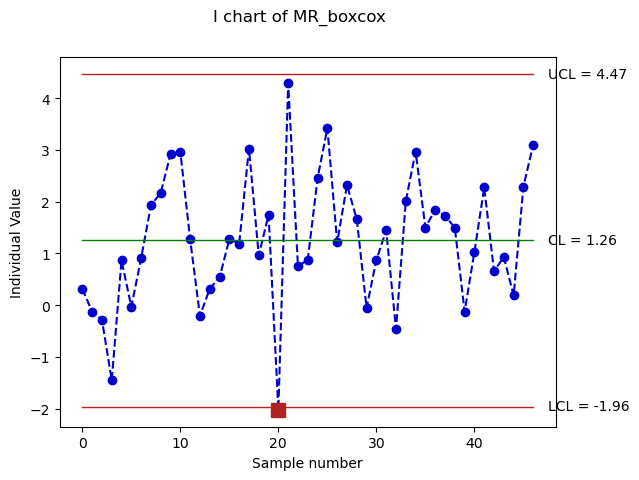

In [35]:
#non c'è assingable cause, vediamo se facendo boxcox cambia:
df_MR_boxcox=mf.IonMRresBoxCox(df_SCC, use04='no',alpha=1/250) 
#qui è all'indice 20 l'OOC,ossia il 21esimo, ossia il 21+2=23esima osservazione originale
#quindi non sono nemmeno gli stessi

From historical data, it is known that the most appropriate model for this process yielded a standard 
deviation of residuals equal to 𝜎𝜀 = 2.5. Determine, with a statistical test, if the model fitted at point a) is 
such that the standard deviation of residuals is greater than this value (report also the p-value of the test). 
Discuss the result. 

In [36]:
sigma=2.5
residual_standard_error = np.sqrt(model.mse_resid) 
[chi2,critical_values,p_value]=mf.chi2_test(residual_standard_error**2,sigma**2,48-1,direction= 'greater',alpha=0.05) #'greater'vuol dire H1: var_data > var_H0

#accettiamo cosa? che siano uguali!!!

the value of the test statistic (n-1)*(S^2/sigma0^2) is 57.870
critical value is 64.001

p_value is 0.133

we have to accept
